<a href="https://colab.research.google.com/github/uptrain-ai/uptrain/blob/main/examples/root_cause_analysis/rag_with_citation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center">
  <a href="https://uptrain.ai">
    <img width="300" src="https://user-images.githubusercontent.com/108270398/214240695-4f958b76-c993-4ddd-8de6-8668f4d0da84.png" alt="uptrain">
  </a>
</h1>

<h1 style="text-align: center;">Root Cause Analysis</h1>

<h2 style="text-align: center;">Failure Cases in a RAG Pipeline</h2>

By the end of this tutorial, you will be able to:
- Understand different failure modes of an RAG pipeline
- Learn how to use UpTrain to perform Root Cause Analysis and assign error mode for each of the failure cases.
- Get actionable insights to resolve those failures and improve your RAG pipeline

Let's start by understanding what RAG is and how this tutorial will help you.

## What is RAG?

RAG is the process of utilising external knowledge in your LLM-based application. 

**For example:** Imagine an LLM-powered chatbot that answers users' queries by leveraging a set of FAQs and knowledge documents outlining the company's customer support policies.

The LLM consumes the user query along with relevant information (context retrieved by vector database) and produces a response to solve the user query along with citations of the different sources which were actually utilized by the LLM for generating the response.

## How will this tutorial help?

So you have built an RAG application. The next step is to test it, find failure cases, and fix them. However, debugging these failure cases is not straightforward. There could be multiple reasons for failure—maybe the retrieval failed, the LLM is not able to utilize the retrieved context to generate a good response, it hallucinated, or even the user query itself was not clear.

To aide with this, UpTrain provides root cause analysis tools to figure out what exactly is going wrong with each failure case. RAG_WITH_CITATION is one such RCA template that helps in debugging RAG applications that output cited responses.

|Failure Case|Explanation|Example|
|--|--|--|
|**Poor Context Utilization**|The LLM is not able to utilize all the information present in the context|The user asks "Do you offer same-day delivery?" The LLM replies, "I am not sure", even if the retrieved context has information that same-day delivery is not possible|
|**Poor Retrieval**|The context given to an LLM does not have information relevant to the question|The user asks "Do you deliver to Bangalore?" but the context does not have any information to deliveries in Bangalore|
|**Hallucinations**|The generated response is not supported by information present in the context|The LLM generates a response "We deliver to Bangalore" when the information present in the context is: "We are going to start delivers in Bangalore soon" |
|**Incorrect Citation**|While the response is correct, it's not correctly cited, eroding users' trust|The LLM cites "We deliver to Delhi" from the context for a response saying "We deliver to Bangalore"|
|**Incomplete Question**|The user's question itself is unclear or does not make sense|The user asks something like: "delivery?", "What location?", "ajdjwsp"|

## How does it Work?
Let's jump to the code

### Step 1: Install UpTrain
You can use UpTrain's open source offering to find failure cases in your RAG pipeline.

Also, everything works locally on your system, which helps you maintain confidentiality of your data.

In [1]:
%pip install uptrain

### Step 2: Let's define a sample dataset to run evaluations

UpTrain uses these 4 parameters to perform RCA on your RAG pipeline:

|Parameter|Explanation|
|--|--|
|question|This is the query asked by your user.|
|context|This is the context that you pass to an LLM (retrieved-context)|
|response|The response generated by the LLM|
|cited_context|The relevant portion of the retrieved context that the LLM cites along with the response.|

In [5]:
data = [
    {
        "question": "Can FedL deliver electronic devices?",
        "context": "FedL was established in 2020. Using FedL you can send deliveries to over 1000+ cities in India including major cities like Bangalore, Mumbai and Delhi. Recently we crossed a milestone by completing 1 million deliveries. Using FedL you can deliver any goods under 10kg(not more than that) to anyone whether it be your friends or family. P.S.: We can't deliver electronic devices. You can also use FedL to deliver a car.",
        "response": "FedL offers deliveries to over 1000+ cities.",
        "cited_context": "Using FedL you can send deliveries to over 1000+ cities in India including major cities like Bangalore, Mumbai and Delhi.",        
    },
    {
        "question": "Can I send a delivery to my friend living in the USA?",
        "context": "FedL was established in 2020. Using FedL you can send deliveries to over 1000+ cities in India including major cities like Bangalore, Mumbai and Delhi. Recently we crossed a milestone by completing 1 million deliveries. Using FedL you can deliver any goods under 10kg(not more than that) to anyone whether it be your friends or family. P.S.: We can't deliver electronic devices. You can also use FedL to deliver a car.",
        "response": "No, FedL does not operate outside of India.",
        "cited_context": "Using FedL you can send deliveries to over 1000+ cities in India",        
    },
    {
        "question": "Can I send a car through FedL?",
        "context": "FedL was established in 2020. Using FedL you can send deliveries to over 1000+ cities in India including major cities like Bangalore, Mumbai and Delhi. Recently we crossed a milestone by completing 1 million deliveries. Using FedL you can deliver any goods under 10kg(not more than that) to anyone whether it be your friends or family. P.S.: We can't deliver electronic devices. You can also use FedL to deliver a car.",
        "response": "No, you can't use FedL to send a car.",
        "cited_context": "Using FedL you can deliver any goods under 10kg(not more than that) to anyone whether it be your friends or family.",        
    },
    {
        "question": "Can I use FedL to send my car which weighs 1000kg?",
        "context": "FedL was established in 2020. Using FedL you can send deliveries to over 1000+ cities in India including major cities like Bangalore, Mumbai and Delhi. Recently we crossed a milestone by completing 1 million deliveries. Using FedL you can deliver any goods under 10kg(not more than that) to anyone whether it be your friends or family. P.S.: We can't deliver electronic devices. You can also use FedL to deliver a car.",
        "response": "Yes, you can use FedL to deliver your 1000kg car .",
        "cited_context": "Using FedL you can deliver any goods under 10kg(not more than that) to anyone whether it be your friends or family.",        
    },
    {
        "question": "Delivery?",
        "context": "FedL was established in 2020. Using FedL you can send deliveries to over 1000+ cities in India including major cities like Bangalore, Mumbai and Delhi. Recently we crossed a milestone by completing 1 million deliveries. Using FedL you can deliver any goods under 10kg(not more than that) to anyone whether it be your friends or family. P.S.: We can't deliver electronic devices. You can also use FedL to deliver a car.",
        "response": "Your question seems incomplete, can you provide some more context about your query.",
        "cited_context": "",        
    }
]

### Step 3: Perform failure analysis using UpTrain

Here we will be using an instance of `EvalLLM` to perform RCA on your RAG pipeline. 

You need an OpenAI key to generate evaluations using UpTrain.

In [3]:
from uptrain import RcaTemplate, EvalLLM
import json

OPENAI_API_KEY = "sk-***********"  # Insert your OpenAI API key here

eval_client = EvalLLM(openai_api_key=OPENAI_API_KEY)

res = eval_client.perform_root_cause_analysis(
    data = data,
    rca_template = RcaTemplate.RAG_WITH_CITATION
)

### Step 4: Let's look at the results
Key information present in your results:
|Parameter|Explanation|
|--|--|
|**error_mode**|The specific failure reason identified in your data|
|**error_resolution_suggestion**|Actionable insights to improve your RAG pipeline|

Besides this the results also provide scores to different aspects of your data along with reasoning.

You can also look at our [docs](https://docs.uptrain.ai/predefined-evaluations/overview) to know more about these evaluations.

In [9]:
import json
print(json.dumps(res[0], indent = 3))

{
   "question": "Can FedL send a delivery to Bangalore?",
   "context": "FedL was established in 2020. Using FedL you can send deliveries to over 1000+ cities in India including major cities like Bangalore, Mumbai and Delhi. Recently we crossed a milestone by completing 1 million deliveries. Using FedL you can deliver any goods under 10kg(not more than that) to anyone whether it be your friends or family. P.S.: We can't deliver electronic devices. You can also use FedL to deliver a car.",
   "response": "FedL offers deliveries to over 1000+ cities.",
   "cited_context": "Using FedL you can send deliveries to over 1000+ cities in India including major cities like Bangalore, Mumbai and Delhi.",
   "error_mode": "Poor Context Utilization",
   "error_resolution_suggestion": "Add intermediary steps so as the LLM can better understand context and generate a complete response",
   "score_question_completeness": 1,
   "score_valid_response": 1.0,
   "explanation_valid_response": "The response

## What's the logic behind this?

Before we move on to the results let's look at how these error modes are identified.

Here's the decision tree behind our analysis:

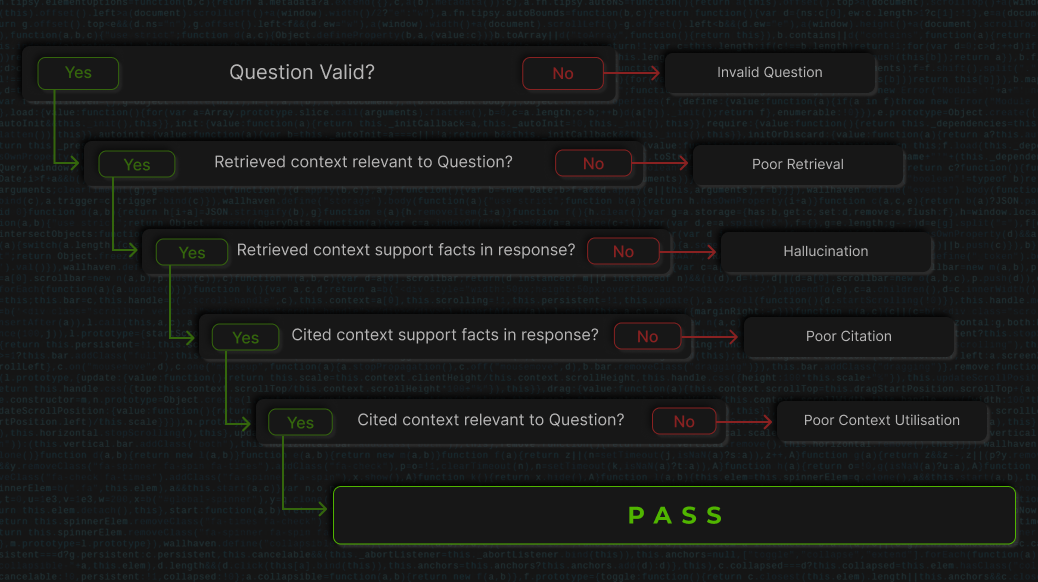

## Let's verify these results

For your ease here are is the complete information mentioned in the context we have used:
1. FedL was established in 2020. 
2. Using FedL you can send deliveries to over 1000+ cities in India including major cities like Bangalore, Mumbai and Delhi. 
3. Recently we crossed a milestone by completing 1 million deliveries. 
4. Using FedL you can deliver any goods under 10kg(not more than that) to anyone whether it be your friends or family. 
5. P.S.: We can't deliver electronic devices. You can also use FedL to deliver a car.

### Poor Context Utilization
**When the LLM is not able to utilize all the information present in the context**

In [7]:
data[0]

{'question': 'Can FedL deliver electronic devices?',
 'context': "FedL was established in 2020. Using FedL you can send deliveries to over 1000+ cities in India including major cities like Bangalore, Mumbai and Delhi. Recently we crossed a milestone by completing 1 million deliveries. Using FedL you can deliver any goods under 10kg(not more than that) to anyone whether it be your friends or family. P.S.: We can't deliver electronic devices. You can also use FedL to deliver a car.",
 'response': 'FedL offers deliveries to over 1000+ cities.',
 'cited_context': 'Using FedL you can send deliveries to over 1000+ cities in India including major cities like Bangalore, Mumbai and Delhi.'}

Here we can see that the user whether FedL can deliver electronic devices or not. Even though the context clearly states that it is not possible, the LLM is not able to utilize it and returns an irrelevant response. 

In [5]:
res[0]['error_mode']

'Poor Context Utilization'

### Poor Retrieval
**When the context given to the LLM doesn't have information related to the question**

In [6]:
data[1]

{'question': 'Can I send a delivery to my friend living in the USA?',
 'context': "FedL was established in 2020. Using FedL you can send deliveries to over 1000+ cities in India including major cities like Bangalore, Mumbai and Delhi. Recently we crossed a milestone by completing 1 million deliveries. Using FedL you can deliver any goods under 10kg(not more than that) to anyone whether it be your friends or family. P.S.: We can't deliver electronic devices. You can also use FedL to deliver a car.",
 'response': 'No, FedL does not operate outside of India.',
 'cited_context': 'Using FedL you can send deliveries to over 1000+ cities in India'}

Here we can see that the user is asking about overseas deliveries.

The context has information about deliveries in India but it doesn't state anything about overseas deliveries.

In [7]:
res[1]['error_mode']

'Poor Retrieval'

### Hallucinations
**When the context given to the LLM can't verify the facts mentioned in the generated response**

In [8]:
data[2]

{'question': 'Can I send a car through FedL?',
 'context': "FedL was established in 2020. Using FedL you can send deliveries to over 1000+ cities in India including major cities like Bangalore, Mumbai and Delhi. Recently we crossed a milestone by completing 1 million deliveries. Using FedL you can deliver any goods under 10kg(not more than that) to anyone whether it be your friends or family. P.S.: We can't deliver electronic devices. You can also use FedL to deliver a car.",
 'response': "No, you can't use FedL to send a car.",
 'cited_context': 'Using FedL you can deliver any goods under 10kg(not more than that) to anyone whether it be your friends or family.'}

Here we can see that the generated responses states that FedL can't deliver cars.

While the context explicitly states that FedL can deliver cars.

In [9]:
res[2]['error_mode']

'Hallucinations'

### Incorrect Citations
**When the generated citations can't verify the facts mentioned in the LLM generated response**

In [10]:
data[3]

{'question': 'Can I use FedL to send my car which weighs 1000kg?',
 'context': "FedL was established in 2020. Using FedL you can send deliveries to over 1000+ cities in India including major cities like Bangalore, Mumbai and Delhi. Recently we crossed a milestone by completing 1 million deliveries. Using FedL you can deliver any goods under 10kg(not more than that) to anyone whether it be your friends or family. P.S.: We can't deliver electronic devices. You can also use FedL to deliver a car.",
 'response': 'Yes, you can use FedL to deliver your 1000kg car .',
 'cited_context': 'Using FedL you can deliver any goods under 10kg(not more than that) to anyone whether it be your friends or family.'}

Here we can see that the generated responses states that FedL can deliver a 1000kg car.

But, the citation explicitly states that FedL can't deliver orders above 1000kg.

Rather the actual citation should be "You can also use FedL to deliver a car.".

In [11]:
res[3]['error_mode']

'Poor citation'

### Incomplete Question
**When the user's query itself doesn't make sense**

In [12]:
data[4]

{'question': 'Delivery?',
 'context': "FedL was established in 2020. Using FedL you can send deliveries to over 1000+ cities in India including major cities like Bangalore, Mumbai and Delhi. Recently we crossed a milestone by completing 1 million deliveries. Using FedL you can deliver any goods under 10kg(not more than that) to anyone whether it be your friends or family. P.S.: We can't deliver electronic devices. You can also use FedL to deliver a car.",
 'response': 'Your question seems incomplete, can you provide some more context about your query.',
 'cited_context': ''}

Here we can see that the user query itself is incomplete and more information is needed from the user.

In [13]:
res[4]['error_mode']

'Incomplete Question'

## Need Help? 

If you need any help using UpTrain or have any suggestions to make it better, you can directly [book a call](https://calendly.com/uptrain-sourabh/30min) with Sourabh (our CEO) and the maintainer of UpTrain.